In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F

# --- UNet Architecture ---
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)
    def forward(self, x):
        return self.conv(x)

class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )
    def forward(self, x):
        return self.mpconv(x)
class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)
    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.outc(x)

In [ ]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# --- Config ---
WIDTH = 256 # if this changed the masking will not work :(
HEIGHT = 256 # if this changed the masking will not work :(
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load Model ---
model = UNet(n_channels=3, n_classes=13).to(device)
model.load_state_dict(torch.load("unet_trained.pth", map_location=device))
model.eval()

C:\Users\menna\AppData\Local\Temp\ipykernel_33996\3198399595.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unet_trained.pth", map_lo

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2

🧠 Predicted class IDs: [ 0  1  6 12]


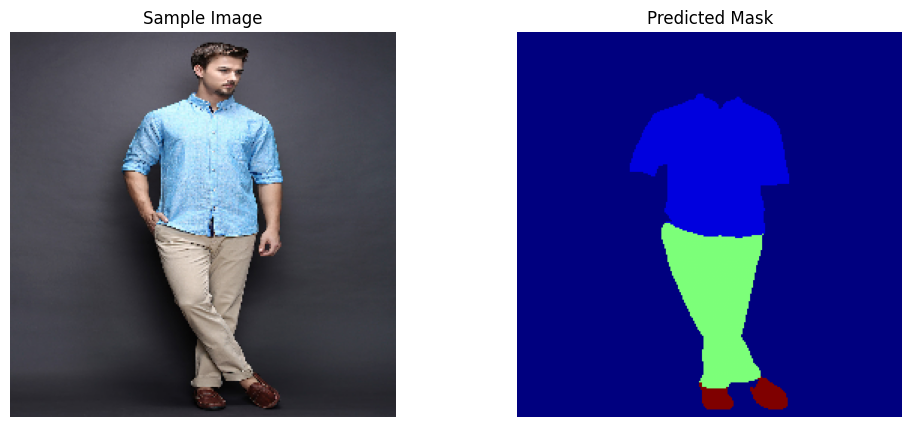

✅ Saved: output_masks\11342_Topwear.png
✅ Saved: output_masks\11342_Bottomwear.png
✅ Saved: output_masks\11342_Shoes.png
⚠️ Skipped Dress (only 0.00% of image)
⚠️ Skipped Skirt (only 0.00% of image)


In [ ]:

final_output_dir = "output_masks" ## Change this 
os.makedirs(final_output_dir, exist_ok=True)

# --- Image Transform (match training) ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # if this changed the masking will not work :(
])

# --- Visualization Function --- No need in backend 
def show_sample(img, prediction):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].imshow(np.transpose(img, (1, 2, 0)))
    axs[0].set_title("Sample Image")
    axs[0].axis("off")
    axs[1].imshow(prediction, cmap='jet')
    axs[1].set_title("Predicted Mask")
    axs[1].axis("off")
    plt.show()
    
    
def test_image(img_path):
    image_id = os.path.splitext(os.path.basename(img_path))[0]

    # Load image
    img = cv2.imread(img_path)
    if img is None:
        print(f"❌ Error: Cannot load {img_path}")
        return

    img = cv2.resize(img, (WIDTH, HEIGHT))
    original_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_input = img.transpose((2, 0, 1))
    img_input = np.expand_dims(img_input, axis=0)
    img_input = torch.tensor(img_input, dtype=torch.float32).to(device) / 255.0

    # Predict
    with torch.no_grad():
        output = model(img_input)
        pred_mask = output[0].argmax(0).cpu().numpy()

    print("🧠 Predicted class IDs:", np.unique(pred_mask))  # Debug line

    # Class mapping The ID need to stay as it is, do not change it
    class_id_to_category_color = {
        1: ("Topwear", (0, 0, 222)),
        6: ("Bottomwear", (124, 255, 121)),
        12: ("Shoes", (127, 0, 0)),
        10: ("Dress", (255, 70, 0)),
        8: ("Skirt", (255, 229, 0))
    }

    # Visualize prediction
    mask_rgb = np.zeros((HEIGHT, WIDTH, 3), dtype=np.uint8)
    for class_id, (_, color) in class_id_to_category_color.items():
        mask_rgb[pred_mask == class_id] = color
    show_sample(original_rgb.transpose((2, 0, 1)), pred_mask)

    total_pixels = HEIGHT * WIDTH

    # Save category masks only if ≥ 5% of image
    for class_id, (category, _) in class_id_to_category_color.items():
        binary_mask = (pred_mask == class_id).astype(np.uint8) * 255
        area_percent = np.count_nonzero(binary_mask) / total_pixels

        if area_percent >= 0.005:
            masked = cv2.bitwise_and(original_rgb, original_rgb, mask=binary_mask)
            rgba = cv2.cvtColor(masked, cv2.COLOR_RGB2RGBA)
            rgba[:, :, 3] = binary_mask
            save_path = os.path.join(final_output_dir, f"{image_id}_{category}.png")
            Image.fromarray(rgba).save(save_path)
            print(f"✅ Saved: {save_path}")
        else:
            print(f"⚠️ Skipped {category} (only {area_percent*100:.2f}% of image)")


# --- Run ---
test_image("11342.jpg")  # Replace with your image